In [1]:
import SimpleITK as sitk
import numpy as np
import os
import pandas as pd
import scipy.ndimage
from skimage.segmentation import clear_border
import pylab

In [2]:
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

### Fonctions

In [3]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [4]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

In [5]:
from pre_processing import get_segmented_lungs

In [6]:
def segment_lung_from_ct_scan(ct_scan,seuil):
    return np.asarray([get_segmented_lungs(slice,seuil) for slice in ct_scan])

In [7]:
'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ca in cands.values:
        #get middel x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        
                        mask_x = int(max(0,min(image_mask.shape[0]-1,coords[0])))
                        mask_y = int(max(0,min(image_mask.shape[1]-1,coords[1])))
                        mask_z = int(max(0,min(image_mask.shape[2]-1,coords[2])))

                        image_mask[mask_x,mask_y,mask_z] = int(1)

    return image_mask

In [8]:
'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, cands, imageName,path):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
    lung_img = lung_img + 1024
    lung_mask = segment_lung_from_ct_scan(lung_img,seuil=604)
    lung_img = lung_img - 1024

    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape	
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = np.round(offset/2)
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
    np.save(path + imageName + '_lung_img.npz', lung_img_512)
    np.save(path + imageName + '_lung_mask.npz', lung_mask_512)
    np.save(path + imageName + '_nodule_mask.npz', nodule_mask_512)
    
    #return
    return lung_img,lung_img_512

### Pre_processing

In [10]:
INPUT_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/subset0'
patients_short = os.listdir(INPUT_FOLDER)

images = os.listdir(INPUT_FOLDER)
images_path = [os.path.join(INPUT_FOLDER,patient) for patient in patients_short]

In [11]:
pos = 4

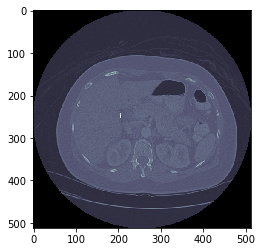

In [12]:
first_image = load_itk(images_path[pos])

plt.imshow(first_image[0][pos],cmap=pylab.cm.bone)

In [13]:
##annotations.csv contient l'id, x, y, z et le diametre des nodules malades
cands = pd.read_csv('/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/csv/annotations.csv')

##labels.csv contient l'id, x, y, z et si le nodules est malade ou non
labels = pd.read_csv('/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/csv/candidates.csv')

##Liste des cands pour chaque image
cands_list = []
for i in range(0,len(images)):
    cands_list.append(cands[cands['seriesuid'] == images[i][0:-4]])
    
##Liste des annotations pour chaque image
labels_list = []
for i in range(0,len(images)):
    labels_list.append(labels[labels['seriesuid'] == images[i][0:-4]])

In [14]:
##On ne garde que les images en .mhd
images_mhd = [] 
for i in range(0,len(images)):
    if images[i][-4:] == '.mhd':
        images_mhd.append(images[i])
        
images_mhd_path = [os.path.join(INPUT_FOLDER,mhd) for mhd in images_mhd]
print(images_mhd[0])
print(images_mhd_path[0])

1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd


In [15]:
first_img, origin, spacing = load_itk(images_path[pos])

In [16]:
img_mask = draw_circles(first_img, cands_list[pos], origin, spacing)

In [17]:
cands_list[pos].shape

(1, 5)

In [19]:
processed_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/'
lung_img,lung_img_512 = create_nodule_mask(images_mhd_path[pos], cands_list[pos], images_mhd[pos][0:-4],processed_folder)

IndexError: index 334 is out of bounds for axis 1 with size 334

In [96]:
plt.imshow(lung_img_512[300],cmap = pylab.cm.bone)

NameError: name 'lung_img_512' is not defined

In [ ]:
processed = os.listdir(processed_folder)
processed_path = [os.path.join(processed_folder,p) for p in processed]

nodule_mask = np.load(processed_path[1])
#lung_img = np.load(processed_path[2])

nodule_pos = np.where(nodule_mask==1)

### UNET

In [9]:
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, Convolution2D, MaxPooling3D, MaxPooling2D
from keras import layers
from keras import Model
from keras.utils import np_utils
from keras import backend as K

/Users/anthonypamart/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [11]:
class DataGenerator(object):
    'Generates data for Keras'
    def __init__(self, dim_x = 512, dim_y = 512, dim_z = 1, batch_size = 32, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def generate(self,list_IDs,INPUT_FOLDER):
        #'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)
            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                # Generate data
                X, Y = self.__data_generation(list_IDs_temp,INPUT_FOLDER)

                yield X, Y
                    
    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self,list_IDs_temp,INPUT_FOLDER):
        #'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        Y = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        # Generate data

        for i, ID in enumerate(list_IDs_temp):
            # Store volume
            X[i, :, :, 0] = np.load(INPUT_FOLDER + '/' + ID + '_lung_img.npz.npy')
            # Store class
            Y[i,:,:,0] = np.load(INPUT_FOLDER + '/' + ID + '_nodule_mask.npz.npy')
        return X, Y

### UNET-VERIFICATION

In [12]:
def generate_list_ID(folder):
	np_list = os.listdir(folder)
	list_IDs = []
	for i,name in enumerate(np_list):
		if name[-16:-8] == "lung_img":
			list_IDs.append(name[0:-17])
	return list_IDs

In [13]:
h5_folder = '/Users/anthonypamart/Documents/SIR/Projets/CEI/15mars/h5'
import keras.losses
import keras.metrics
from keras.models import load_model

In [14]:
keras.losses.dice_coef_loss = dice_coef_loss
keras.metrics.dice_coef = dice_coef
model_path_init = os.path.join(h5_folder,'UNET-0')
model = load_model(model_path_init)

/Users/anthonypamart/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)
/Users/anthonypamart/anaconda2/lib/python2.7/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


__Tester avec une image test et une image train__

In [15]:
from pre_processing import *

In [17]:
%%time
SUBSET_FOLDER = '/Users/anthonypamart/Documents/SIR/Projets/CEI/DonneesKaggle/sample_images/'
patients = os.listdir(SUBSET_FOLDER)
patients.sort()
del patients[0]

first_patient_path = os.path.join(SUBSET_FOLDER,patients[0])

patient = load_scan(first_patient_path)
image = PixelData_to_HU(patient)
image, space = resample(image, patient)
image = np.stack([get_segmented_lungs(s) for s in image])

CPU times: user 23.5 s, sys: 293 ms, total: 23.8 s
Wall time: 24 s


In [18]:
im = zero_padding(image,max_z=image.shape[0],max_x=512,max_y=512)

In [19]:
im2 = im.copy()
im2[im2==0] = -1024

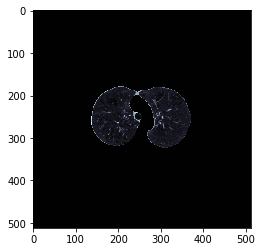

In [88]:
plt.imshow(im2[250],cmap=pylab.cm.bone)
plt.show()

In [46]:
#path = '/Users/anthonypamart/Documents/SIR/Projets/CEI/Donnees Kaggle dans UNET/Lung_img dans UNET/'
#for i in range(0, im2.shape[0]):
#    np.save(path + str(i) + '_lung_img.npz', im2[i])

In [49]:
#%%time
#path = '/Users/anthonypamart/Documents/SIR/Projets/CEI/Donnees Kaggle dans UNET/Mask_Nodule en sortie/'
#for i in range(0, im2.shape[0]):
#    prediction = np.empty((1,512,512,1))
#    prediction[0,:,:,0] = im2[i]
#    predict_subset = model.predict(prediction)
#    np.save(path + str(i) + '_mask_nodule.npz', predict_subset)

CPU times: user 2h 59min 14s, sys: 9min 54s, total: 3h 9min 8s
Wall time: 54min 31s


In [47]:
%%time
numero = 50
prediction = np.empty((1,512,512,1))
prediction[0,:,:,0] = im2[numero]
predict_subset = model.predict(prediction)
print(np.sum(im2[numero])/(1024*512*512))

-1
CPU times: user 32 s, sys: 1.72 s, total: 33.7 s
Wall time: 9.28 s


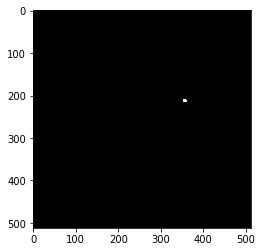

In [30]:
plt.imshow(predict_subset[0,:,:,0],cmap=pylab.cm.bone)
plt.show()

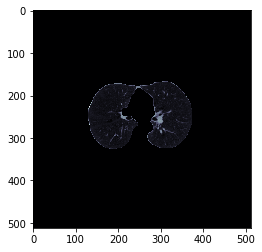

In [31]:
plt.imshow(im2[200], cmap=pylab.cm.bone)
plt.show()

In [101]:
params = {'dim_x': 512,
	          'dim_y': 512,
	          'dim_z': 1,
	          'batch_size': 1,
	          'shuffle': False}
SUBSET_FOLDER = '/Users/anthonypamart/Documents/SIR/Projets/CEI/15mars/slices'
list_IDs_subset = generate_list_ID(SUBSET_FOLDER)
subset_generator = DataGenerator(**params).generate(list_IDs_subset,SUBSET_FOLDER)

In [102]:
numero = 5
lung_to_predict = np.empty((1,512,512,1))
lung_to_predict[0,:,:,0] = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_lung_img.npz.npy'))
predict_subset = model.predict(lung_to_predict)

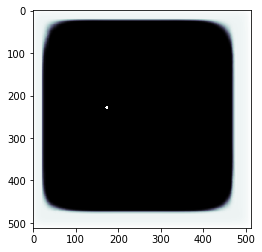

In [105]:
plt.imshow(predict_subset[0,:,:,0],cmap=pylab.cm.bone)
plt.show()

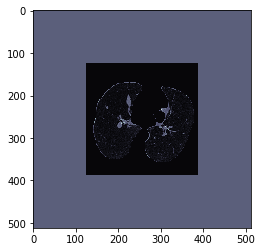

In [104]:
numero = 5
plt.imshow(lung_to_predict[0,:,:,0],cmap=pylab.cm.bone)
plt.show()

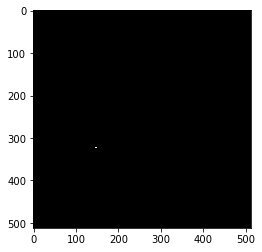

In [144]:
mask_real = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_nodule_mask.npz.npy'))
plt.imshow(mask_real,cmap=pylab.cm.bone)